In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
import numpy as np
from utils import read_labels, draw_image, image_to_yolo_input, Object, parse_annotation, Annotation, calculate_IoU, image_to_vgg_input
from PIL import Image as Img
import os

tf.enable_eager_execution()
tf.executing_eagerly()

True

In [2]:
#TODO: read from config

image_width = 160 #416
image_height = 160 #416
grid_width = int(image_width / 32) # 13
grid_height = int(image_height / 32) # 13

cell_width = image_width / grid_width
cell_height = image_height / grid_height

boxes = 5

activation_alpha = 0.1

object_scale = 5
noobject_scale = 1
class_scale = 1
coord_scale = 1

threshhold = 0.3

anchors = [[1.05, 1.65], [2.44, 4.13], [4.01, 8.46], [7.62, 5.13], [9.97, 10.43]] # obtained from KMeans experiments ipynb

batch_size = 1

labels_dir = "./labels.txt"

annotation_folder = '.\VOCdevkit\VOC2007\Annotations'
images_folder = '.\VOCdevkit\VOC2007\JPEGImages'

test_annotation = r'.\VOCdevkit\VOC2007\Annotations\000019.xml'
test_image = r'.\VOCdevkit\VOC2007\JPEGImages\000019.jpg'

In [3]:
labels, labels_count = read_labels(labels_dir)


labels_count = 0 # TODO: remove when implementing classification

print(labels_count)
print(labels)

0
['horse', 'diningtable', 'sofa', 'train', 'bird', 'aeroplane', 'person', 'boat', 'bottle', 'motorbike', 'bus', 'cat', 'pottedplant', 'car', 'dog', 'bicycle', 'sheep', 'cow', 'tvmonitor', 'chair']


In [4]:
layers = []

layers.append(Input(shape=(image_width, image_height, 3)))

layers.append(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_1"))
layers.append(BatchNormalization(name = "norm_1"))
layers.append(LeakyReLU(name = "leaky_1", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_1"))

layers.append(Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_2"))
layers.append(BatchNormalization(name = "norm_2"))
layers.append(LeakyReLU(name = "leaky_2", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_2"))

layers.append(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_3"))
layers.append(BatchNormalization(name = "norm_3"))
layers.append(LeakyReLU(name = "leaky_3", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_3"))

layers.append(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_4"))
layers.append(BatchNormalization(name = "norm_4"))
layers.append(LeakyReLU(name = "leaky_4", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_4"))

layers.append(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_5"))
layers.append(BatchNormalization(name = "norm_5"))
layers.append(LeakyReLU(name = "leaky_5", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_5"))

layers.append(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_6"))
layers.append(BatchNormalization(name = "norm_6"))
layers.append(LeakyReLU(name = "leaky_6", alpha = activation_alpha))
#layers.append(MaxPooling2D(name = "maxpool_6", pool_size = (2, 2), strides = (1, 1)))

layers.append(Conv2D(filters = 1024, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_7"))
layers.append(BatchNormalization(name = "norm_7"))
layers.append(LeakyReLU(name = "leaky_7", alpha = activation_alpha))

layers.append(Conv2D(filters = 1024, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_8"))
layers.append(BatchNormalization(name = "norm_8"))
layers.append(LeakyReLU(name = "leaky_8", alpha = activation_alpha))

layers.append(Conv2D(filters = (boxes * (4 + 1 + labels_count)), kernel_size = (1, 1), padding = "same", name="conv_9"))

layers.append(Reshape(target_shape = (grid_width, grid_height, boxes, 5 + labels_count), name = "output"))

tinyyolov2 = Sequential(layers = layers, name = "tiny yolov2 voc")
tinyyolov2.summary()

Model: "tiny yolov2 voc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 160, 160, 16)      432       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 160, 160, 16)      64        
_________________________________________________________________
leaky_1 (LeakyReLU)          (None, 160, 160, 16)      0         
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 80, 80, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 32)        4608      
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 80, 80, 32)        128       
_________________________________________________________________
leaky_2 (LeakyReLU)          (None, 80, 80, 32)    

In [5]:
def get_annotations_images(annotations_dir, images_dir):
    image_formats = ['.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif']
    
    annons, images = [], []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(annotations_dir):
        for file in f:
            if '.xml' in file:
                image_exists = False
                for im_format in image_formats:
                    image_name = file[:-4] + im_format
                   
                    image_path = images_dir + '\\' + image_name
                    
                    if os.path.exists(image_path):
                        image_exists = True
                        break
                        
                if image_exists:
                    annons.append(annotations_dir + '\\' + file)
                    images.append(images_dir + '\\' + image_name)

    annons = annons[:500]
    images = images[:500]
    
    return annons, images

def inverse_sigmoid(x):
    return np.log(x / (1 - x))

def encode_y_true_from_annotatoin(annotation):    
    y_true = np.zeros(shape = (grid_width, grid_height, boxes, 5 + labels_count))
    objs = [[[] for col in range(grid_width)] for row in range(grid_height)]
    
    annotation = parse_annotation(annotation)
    
    cell_width = annotation.imagewidth / grid_width
    cell_height = annotation.imageheight / grid_height
    
    for obj in annotation.objects:
        obj.xmid = (obj.xmax + obj.xmin) / 2
        obj.ymid = (obj.ymax + obj.ymin) / 2
        obj.width = obj.xmax - obj.xmin
        obj.height = obj.ymax - obj.ymin

        row = int(obj.ymid / cell_height)
        col = int(obj.xmid / cell_width)

        objs[row][col].append(obj)        
    
        best_anchor_index = 0
        best_IoU = -1
        
        for index in range(boxes):
            anchor_w, anchor_h = anchors[index]
            
            width = anchor_w * cell_width
            height = anchor_h * cell_height
            
            anchor_object = Object(xmin = obj.xmin, xmax = obj.xmax + width, ymin = obj.ymin, ymax = obj.ymax + height)
            
            current_IoU = calculate_IoU(obj, anchor_object)
            if current_IoU > best_IoU:
                best_IoU = current_IoU
                best_anchor_index = index
                   

            sx = obj.xmid / cell_width - col
            sy = obj.ymid / cell_height - row
            
            # so that i don't get divison over 0 in inverse sigmoid
            if sx == 1.0:
                sx += 0.000001
            if sy == 1.0:
                sy += 0.000001
            
            x = inverse_sigmoid(sx)
            y = inverse_sigmoid(sy)
            
            w = np.log(obj.width / anchor_w)
            h = np.log(obj.height / anchor_h)            
            c = best_IoU
            
                       
            y_true[row][col][index] = [c, x, y, w, h]
            if np.any(np.isnan(y_true[row][col][[index]])):
                print("BIG REEEEEEEE")
                print(sx)
                print(obj.xmid - (col * cell_width))
                print(inverse_sigmoid(sx))
                return y_true
    
    
    return y_true

# TODO: make it work with any batch size
def custom_loss(y_true, y_pred):    
    c_pred = y_pred[:, :, :, :, 0]
    c_true = y_true[:, :, :, :, 0]

    xpred = y_pred[:, :, :, :, 1]
    ypred = y_pred[:, :, :, :, 2]                
    xtrue = y_true[:, :, :, :, 1]
    ytrue = y_true[:, :, :, :, 2]

    wpred = y_pred[:, :, :, :, 3]
    hpred = y_pred[:, :, :, :, 4]                
    wtrue = y_true[:, :, :, :, 3]
    htrue = y_true[:, :, :, :, 4]

    xy_pred = y_pred[:, :, :, :, 1 : 3]
    xy_true = y_true[:, :, :, :, 1 : 3]

    wh_pred = y_pred[:, :, :, :, 3 : 5]
    wh_true = y_true[:, :, :, :, 3 : 5]

    intermins = tf.maximum(xy_true, xy_pred)
    intermaxes = tf.minimum(xy_true, xy_pred)

    interArea = tf.maximum(0.0, intermaxes[..., 0] - intermins[..., 0] + 1) * tf.maximum(0.0, intermaxes[..., 1] - intermins[..., 1] + 1)

    groundTruthArea = (wh_true[..., 0] + 1) * (wh_true[..., 1] + 1)
    predictedArea = (wh_pred[..., 0] + 1) * (wh_pred[..., 1] + 1)

    iou = interArea / (groundTruthArea + predictedArea - interArea)

    
    mask_shape = (batch_size, grid_width, grid_height, boxes)
    
    objs = tf.ones(shape = (mask_shape)) * object_scale
    noobjs = tf.ones(shape = (mask_shape)) * noobject_scale
    coords = tf.ones(shape = (mask_shape)) * coord_scale
    noobjscoords = tf.zeros(shape = (mask_shape))

    greaters = tf.greater(iou, 0.0)
    confcoef = tf.where(greaters, objs, noobjs)                
    xywhcoef = tf.where(greaters, coords, noobjscoords)
    
    confloss = confcoef * ((c_true - iou) ** 2)
    xyloss = xywhcoef * ((xtrue - xpred) ** 2) + xywhcoef * ((ytrue - ypred) ** 2)
    whloss = xywhcoef * ((wtrue - wpred) ** 2) + xywhcoef * ((htrue - hpred) ** 2)                         
    
    loss = confloss + xyloss + whloss
    
    #print(np.any(np.isnan(xywhcoef)))
    #print(np.any(np.isnan(((xtrue - xpred) ** 2))))
    #print(np.any(np.isnan(xywhcoef * ((xtrue - xpred) ** 2))))
    #print(loss)
    
    return loss

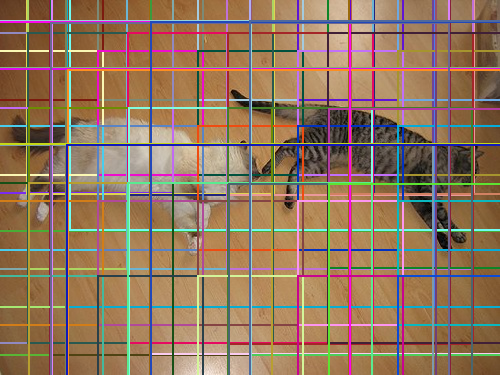

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def decode_prediction(y_pred):
    objects = []
    
    for row in range(grid_height):
        for col in range(grid_width):
            for box in range(boxes):
                to, tx, ty, tw, th = y_pred[row, col, box]
                
                conf = sigmoid(to)
                
                bx = (sigmoid(tx) + col) * cell_width
                by = (sigmoid(ty) + row) * cell_height
                
                pw, ph = anchors[box]
                
                bw = pw * np.exp(tw)
                bh = ph * np.exp(tw)
                
                bw *= cell_width
                bh *= cell_height
                
                
                
                #if conf >= threshhold and row == 3 and col == 3:
                if conf >= threshhold:
                    objects.append(Object(xmin = bx - bw/2, xmax = bx + bw/2, ymin = by - bh/2, ymax = by + bh/2, conf = conf))
    return objects

def feed_forward(model, image_path):
    im = Img.open(image_path)
    
    width_scale = im.width / image_width
    height_scale = im.height / image_height
    
    im = im.resize((image_width, image_height))
    im = np.array(im, np.float32)
    im /= 255
    
    y_pred = model.predict(np.array([im]))[0]
    
    objects = decode_prediction(y_pred)
    
    for obj in objects:
        obj.xmin = obj.xmin * width_scale
        obj.xmax = obj.xmax * width_scale
        obj.ymin = obj.ymin * height_scale
        obj.ymax = obj.ymax * height_scale
    
    draw_image(image_path, objects)
    



feed_forward(tinyyolov2, test_image)

In [7]:
annotations, images = get_annotations_images(annotation_folder, images_folder)
ins = np.array([image_to_vgg_input(image, inputshape = (image_width, image_height)) for image in images], dtype=np.float32)
outs = np.array([encode_y_true_from_annotatoin(annotation) for annotation in annotations], dtype=np.float32)

print(ins.shape)
print(outs.shape)
print('Prepared ins & outs')

C:\Users\Gencho\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


(500, 160, 160, 3)
(500, 5, 5, 5, 5)
Prepared ins & outs


In [8]:
assert not np.any(np.isnan(ins))
assert not np.any(np.isnan(outs))

In [9]:
def get_mobilenetyolov2():
    mobilenetyolov2 = MobileNet(weights ='imagenet', include_top = False, input_shape=(image_width, image_height, 3))
    mobilenetyolov2.trainable = False
    layers = mobilenetyolov2.layers[:]

    layers.append(Conv2D(filters = (boxes * (4 + 1 + labels_count)), kernel_size = (1, 1), padding = "same", name="conv_output"))
    layers.append(Reshape(target_shape = (grid_width, grid_height, boxes, 5 + labels_count), name = "output"))

    mobilenetyolov2 = Sequential(layers = layers, name = "yolov2 mobilenetv2")
    mobilenetyolov2.summary()
    
    return mobilenetyolov2

In [10]:
adam = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
tinyyolov2.compile(optimizer = adam, loss = custom_loss)

print('Model compiled')

W1212 23:36:58.076162 13488 deprecation.py:323] From <ipython-input-5-129ae5348fca>:136: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model compiled


In [11]:
testbatchins = ins[:batch_size]
testbatchouts = outs[:batch_size]

pred = tinyyolov2.predict(testbatchins)
loss = custom_loss(testbatchouts, pred)

assert not np.any(np.isnan(pred))
assert not np.any(np.isnan(loss))

In [ ]:
# TODO: fix exploding gradients problem
gen = tf.keras.preprocessing.image.ImageDataGenerator()

epochs = 10

h = tinyyolov2.fit_generator(gen.flow(x = ins, y = outs, batch_size = batch_size), steps_per_epoch = len(ins) // batch_size, epochs = epochs)

In [ ]:
'''
things to consider:
Lambda layer which decodes output
'''